<h1>Desafio 3 - Grupo 2</h1>

<h3><u>Intregrantes del grupo</u></h3>

- Álvarez, Emiliano
- Gómez, Ronny  
- Otero, Juan Martín   
- Magariños, Néstor   

<h3><u>Objetivos</u></h3>  

- Construir clusters de paises a raiz de indicadores de económicos y sociales  
- Analizar si los clusters se corresponden con agrupaciones geográficas  
- Analizar si los clusters se corresponden con agrupaciones según el índice de felicidad
- Analizar si existen variaciones en los clusters para datos de distintos años (2015-2020)

<h3><u>Dataset</u></h3>
Los datos utilizados fueron extraidos de <a href="https://www.kaggle.com/unsdsn/world-happiness">Kaggle</a> y contienen los resultados anuales de la <a href="https://worldhappiness.report/ed/2020/">Encuesta Mundial de Felicidad</a> realizada por <a href="https://gallup.com">Gallup</a> para el periodo 2015-2020

<h3><u>Indicadores</u></h3>  

- <u>Índice de felicidad:</u> El puntaje de felicidad del país; basado en las respuestas a la pregunta "Del 1 al 10, ¿qué tan feliz es?"

- <u>Logaritmo de PBI per capita:</u> PIB per cápita en términos de paridad del poder adquisitivo (PPA) ajustado a dólares internacionales constantes de 2011
- <u>Índice de apoyo social:</u> Promedio de las respuestas binarias (0 = no, 1 = sí) a la pregunta “Si está en problemas, ¿tiene familiares o amigos con los que pueda contar para ayudarlo siempre que sea necesario?
- <u>Índice de esperanza de vida:</u> Expectativa de vida al nacer
- <u>Índice de libertad:</u> Promedio de respuestas binarias (0 = no, 1 = sí) a la pregunta "¿Está satisfecho o insatisfecho con su libertad para elegir lo que hace con su vida?"
- <u>Índice de generosidad:</u> Promedio de respuestas binarias (0 = no, 1 = sí) a la pregunta "¿Has donado dinero a una organización benéfica en el último mes?" sobre el PIB per cápita.
- <u>Índice de percepción de corrupción:</u> Promedio de respuestas binarias (0 = no, 1 = sí) a la pregunta "¿La corrupción está extendida en el gobierno de tu país?"

<h3><u>Índice</u></h3>

<a href='#section_1'>1. Preparación del dataset</a>   
<a href='#section_2'>2. Análisis preliminar</a>  
<a href='#section_3'>3. Kmeans</a>  
<a href='#section_4'>4. Cluster jerárquico</a>  
<a href='#section_5'>5. DBSCAN</a>
<a href='#section_6'>6. Resultados</a>

---
---
<b><a id='section_1'><h4>1. Preparación del dataset</h4></a></b>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data15 = pd.read_csv("../Data/2015.csv")
data16 = pd.read_csv("../Data/2016.csv")
data17 = pd.read_csv("../Data/2017.csv")
data18 = pd.read_csv("../Data/2018.csv")
data19 = pd.read_csv("../Data/2019.csv")
data20= pd.read_csv("../Data/2020.csv")

Homogenizamos el nombre de las columnas

In [3]:
def add_region(df,Country,Region):
    df=df.append({'Country':Country,'Region':Region}, ignore_index=True)
    return df
def joinearRegion(df,nombrecampoleft):
    df= df.set_index(nombrecampoleft).join(country_region.set_index('Country'),how='left').reset_index()
    return df
def renametodo(df,camposrename):
    df = df.rename(columns=camposrename)
    return df
def creamask(df,texto):
    mask = df.Country ==texto
    return mask
def creamask2(df,texto):
    mask = df["Country or region"] ==texto
    return mask

In [4]:
campos_renombrar = {"Country name": "Country",
 'Overall rank':'OverallRank', 
 'Logged GDP per capita':'GDPperCapita',
 'Social support':'Social_support',
 'Healthy life expectancy':'HealthyLifeExpectancy',
 'Freedom to make life choices':'Freedomchoices',
 'Perceptions of corruption':'PerceptionsOfCorruption',
 'Regional indicator':'Region'
}
data20= renametodo(data20,campos_renombrar)
data20.loc[creamask(data20,"Taiwan Province of China"),"Country"]= "Taiwan"
country_region= data20[['Country',"Region"]]

In [5]:
country_region= add_region(country_region,"Sudan","Sub-Saharan Africa")
country_region= add_region(country_region,"Somalia","Sub-Saharan Africa")
country_region= add_region(country_region,"Syria","Middle East and North Africa")
country_region= add_region(country_region,"Angola","Sub-Saharan Africa")
country_region= add_region(country_region,"Qatar","Middle East and North Africa")
country_region= add_region(country_region,"Belize","Latin America and Caribbean")
country_region= add_region(country_region,"Bhutan","South Asia")

In [6]:
data17.loc[creamask(data17,"Hong Kong S.A.R., China"),"Country"]= "Hong Kong S.A.R. of China"
data17.loc[creamask(data17,"Taiwan Province of China"),"Country"]= "Taiwan"
data18.loc[creamask2(data18,"Hong Kong"),"Country or region"]= "Hong Kong S.A.R. of China"
data19.loc[creamask2(data19,"Hong Kong"),"Country or region"]= "Hong Kong S.A.R. of China"
data19.loc[creamask2(data19,"Trinidad & Tobago"),"Country or region"]= "Trinidad and Tobago"
data18.loc[creamask2(data18,"Trinidad & Tobago"),"Country or region"]= "Trinidad and Tobago"
data19.loc[creamask2(data19,"North Macedonia"),"Country or region"]= "Macedonia"
data18.loc[creamask2(data18,"North Macedonia"),"Country or region"]= "Macedonia"
data19.loc[creamask2(data19,"Northern Cyprus"),"Country or region"]= "Cyprus"
data18.loc[creamask2(data18,"Northern Cyprus"),"Country or region"]= "Cyprus"

In [7]:
campos_renombrar = {
 'Happiness Rank':'OverallRank',
 'Happiness Score':'Happiness',
 'Family':'Social_support',
 'Economy (GDP per Capita)':'GDPperCapita',
 'Health (Life Expectancy)':'HealthyLifeExpectancy',
 'Freedom':'Freedomchoices',
 'Trust (Government Corruption)':'PerceptionsOfCorruption'
}
data15= renametodo(data15,campos_renombrar)

In [8]:
campos_renombrar = {
 'Happiness Rank':'OverallRank',
 'Happiness Score':'Happiness',
 'Economy (GDP per Capita)':'GDPperCapita',
 'Family':'Social_support',
 'Health (Life Expectancy)':'HealthyLifeExpectancy',
 'Freedom':'Freedomchoices',
 'Trust (Government Corruption)':'PerceptionsOfCorruption'
}
data16= renametodo(data16,campos_renombrar)

In [9]:
campos_renombrar = {
 'Happiness.Rank':'OverallRank',
 'Happiness.Score':'Happiness',
 'Economy..GDP.per.Capita.':'GDPperCapita',
 'Family':'Social_support',
 'Health..Life.Expectancy.':'HealthyLifeExpectancy',
 'Freedom':'Freedomchoices',
 'Trust..Government.Corruption.':'PerceptionsOfCorruption',
 'Regional indicator':'Region'
}
data17= renametodo(joinearRegion(data17,'Country'),campos_renombrar)

In [10]:
campos_renombrar = {"Country or region": "Country",
                    "index":"Country",
                    'Score':'Happiness',
 'Overall rank':'OverallRank', 
 'GDP per capita':'GDPperCapita',
 'Social support':'Social_support',
 'Healthy life expectancy':'HealthyLifeExpectancy',
 'Freedom to make life choices':'Freedomchoices',
 'Perceptions of corruption':'PerceptionsOfCorruption',
 'Regional indicator':'Region'
}
data18= renametodo(joinearRegion(data18,'Country or region'),campos_renombrar)

In [11]:
campos_renombrar = {"Country or region": "Country",
 "index":"Country",
 'Overall rank':'OverallRank', 
 'Score':'Happiness',
 'GDP per capita':'GDPperCapita',
 'Social support':'Social_support',
 'Healthy life expectancy':'HealthyLifeExpectancy',
 'Freedom to make life choices':'Freedomchoices',
 'Perceptions of corruption':'PerceptionsOfCorruption',
 'Regional indicator':'Region'
}
data19= renametodo(joinearRegion(data19,'Country or region'),campos_renombrar)

Eliminamos las filas duplicadas y nos quedamos con las mismas columnas para todos los datasets

In [12]:
display(data19.dtypes)
   
data15=data15[data19.columns].drop_duplicates(subset=['Country'])
data16=data16[data19.columns].drop_duplicates(subset=['Country'])
data17=data17[data19.columns].drop_duplicates(subset=['Country'])
data18=data18[data19.columns].drop_duplicates(subset=['Country'])
data19=data19.drop_duplicates(subset=['Country'])

Country                     object
OverallRank                  int64
Happiness                  float64
GDPperCapita               float64
Social_support             float64
HealthyLifeExpectancy      float64
Freedomchoices             float64
Generosity                 float64
PerceptionsOfCorruption    float64
Region                      object
dtype: object

In [13]:
print("data15:",data15.shape)
print("data16:",data16.shape)
print("data17:",data17.shape)
print("data18:",data18.shape)
print("data19:",data19.shape)

data15: (158, 10)
data16: (157, 10)
data17: (155, 10)
data18: (155, 10)
data19: (155, 10)


In [14]:
data15['Year']=2015
data16['Year']=2016
data17['Year']=2017
data18['Year']=2018
data19['Year']=2019

Concatenamos todos los datasets. El dataset de 2020 no fue contemplado debido a que tenía escalas no consistente con las escalas de los indicadores del resto de los años

In [15]:
datasets = [data15,data16,data17,data18,data19]
data_complete =pd.concat(datasets)
data_complete.shape

(780, 11)

Nos quedamos únicamente con los paises que figuran en los 5 años

In [16]:
countries = data_complete['Country'].value_counts()[data_complete['Country'].value_counts() == 5].index
data_complete = data_complete.loc[data_complete['Country'].isin(countries),:]
data_complete.shape

(720, 11)

In [17]:
for column in data_complete.columns:
        if data_complete[column].dtype in ('int32','float64'):
            data_complete[column] = data_complete[column].round(2)     

Importamos el dataset de geopandas que utilizaremos para graficar los mapas

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.drop(['pop_est','iso_a3','gdp_md_est'],axis=1,inplace=True)
world.columns=['Continent','Country','geometry']
world['Country'] = world['Country'].replace({'United States of America': 'United States'})

Homogeneizamos los nombres de los paises entre el dataset de Gallup y el dataset provisto por geopandas

In [19]:
dictCountry= {'Czech Republic': 'Czechia',
'Dominican Republic': 'Dominican Rep.',
'Bosnia and Herzegovina': 'Bosnia and Herz.',
 'Swaziland': 'eSwatini',
'Central African Republic': 'Central African Rep.',
'South Sudan': 'S. Sudan'}

data_complete=data_complete.replace(dictCountry)

In [20]:
indicadores = ['GDPperCapita', 'Social_support',
               'HealthyLifeExpectancy', 'Freedomchoices', 'Generosity',
               'PerceptionsOfCorruption']

---
---
<b><a id='section_2'><h4>2. Análisis preliminar</h4></a></b>

Realizamos un análisis preliminar de las variables para el año 2019

In [21]:
year=2019
data=data_complete.loc[data_complete['Year']==year,:]
data= world.merge(data,on='Country',how='left')

columnas_ordenadas=['Year', 'Country', 'Continent','Region','geometry', 'OverallRank', 'Happiness',
                   'GDPperCapita', 'Social_support', 'HealthyLifeExpectancy',
                   'Freedomchoices', 'Generosity', 'PerceptionsOfCorruption']
data_map =data[columnas_ordenadas]
data = data.loc[data['Happiness'].notnull(),:]
data.reset_index(drop=True,inplace=True)

-----

In [22]:
data_complete.loc[data_complete['Country']=="Bolivia",['Year','GDPperCapita']]

,Year,GDPperCapita
50,2015,0.68
58,2016,0.79
57,2017,0.83
16,2018,0.75
14,2019,0.78


In [23]:
data.describe().round(2)

,OverallRank,Happiness,GDPperCapita,Social_support,HealthyLifeExpectancy,Freedomchoices,Generosity,PerceptionsOfCorruption,Year
count,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.0
mean,75.09,5.50,0.93,1.23,0.75,0.39,0.18,0.11,2019.0
std,44.95,1.10,0.37,0.28,0.21,0.14,0.10,0.09,0.0
min,1.00,3.20,0.05,0.38,0.19,0.00,0.00,0.00,2019.0
25%,37.50,4.62,0.68,1.10,0.60,0.31,0.11,0.04,2019.0
50%,73.50,5.49,1.00,1.31,0.80,0.42,0.18,0.08,2019.0
75%,114.25,6.20,1.23,1.46,0.88,0.51,0.24,0.13,2019.0
max,154.00,7.77,1.68,1.62,1.09,0.63,0.57,0.41,2019.0


In [24]:
data.loc[data['Country']=='Argentina',:]

,Continent,Country,geometry,OverallRank,Happiness,GDPperCapita,Social_support,HealthyLifeExpectancy,Freedomchoices,Generosity,PerceptionsOfCorruption,Region,Year
6,South America,Argentina,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",47.0,6.09,1.09,1.43,0.88,0.47,0.07,0.05,Latin America and Caribbean,2019.0


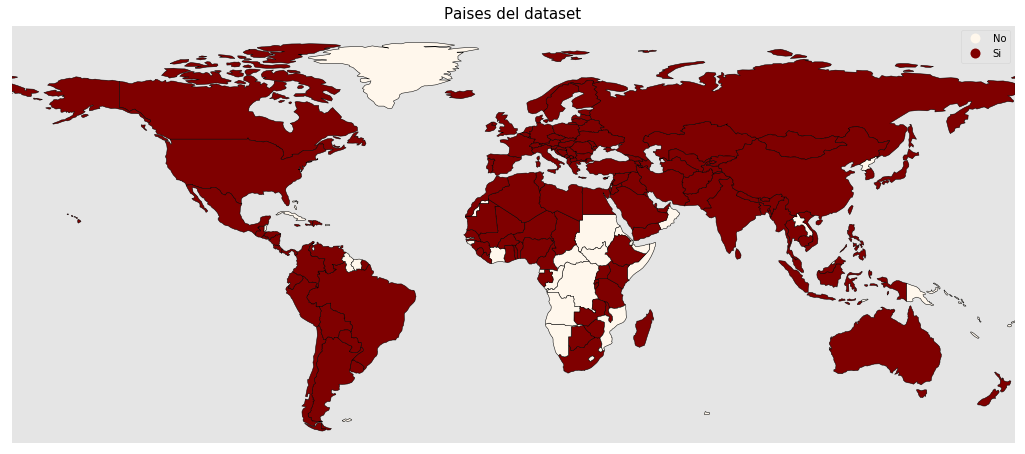

In [25]:
mask_notnull = data_map['Happiness'].notnull()
mask_isnull = data_map['Happiness'].isnull()

data_map.loc[mask_notnull,'Informacion'] = "Si"
data_map.loc[mask_isnull,'Informacion'] = "No"

fig, ax = plt.subplots(figsize=(18, 15))
data_map.plot('Informacion',edgecolor='black', cmap='OrRd',legend=True, ax=ax);
plt.xlim(-180,180)
plt.ylim(-60,90)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Paises del dataset",size=15);

data_map.drop(columns='Informacion',inplace=True)

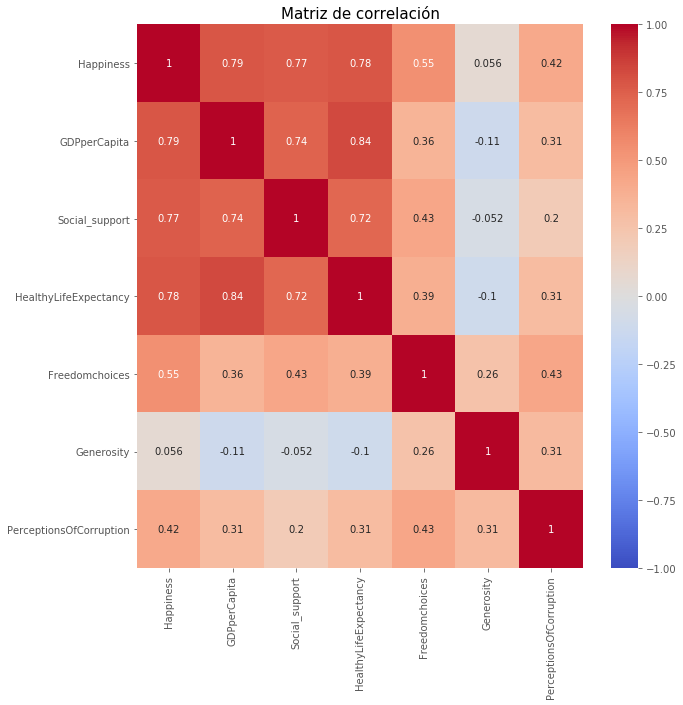

In [26]:
indicadores_matriz = ['Happiness', 'GDPperCapita', 'Social_support',
               'HealthyLifeExpectancy', 'Freedomchoices', 'Generosity',
               'PerceptionsOfCorruption']
plt.figure(figsize=(10,10))
sns.heatmap(data[indicadores_matriz].corr(), annot=True , cmap="coolwarm", vmin=-1,vmax=1)
plt.title("Matriz de correlación",size=15);

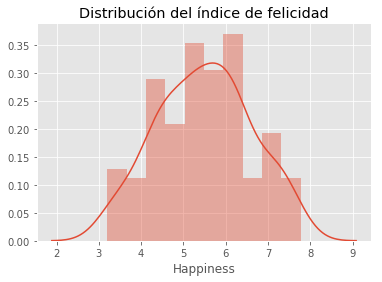

In [27]:
sns.distplot(data['Happiness'],bins=10);
plt.title("Distribución del índice de felicidad");

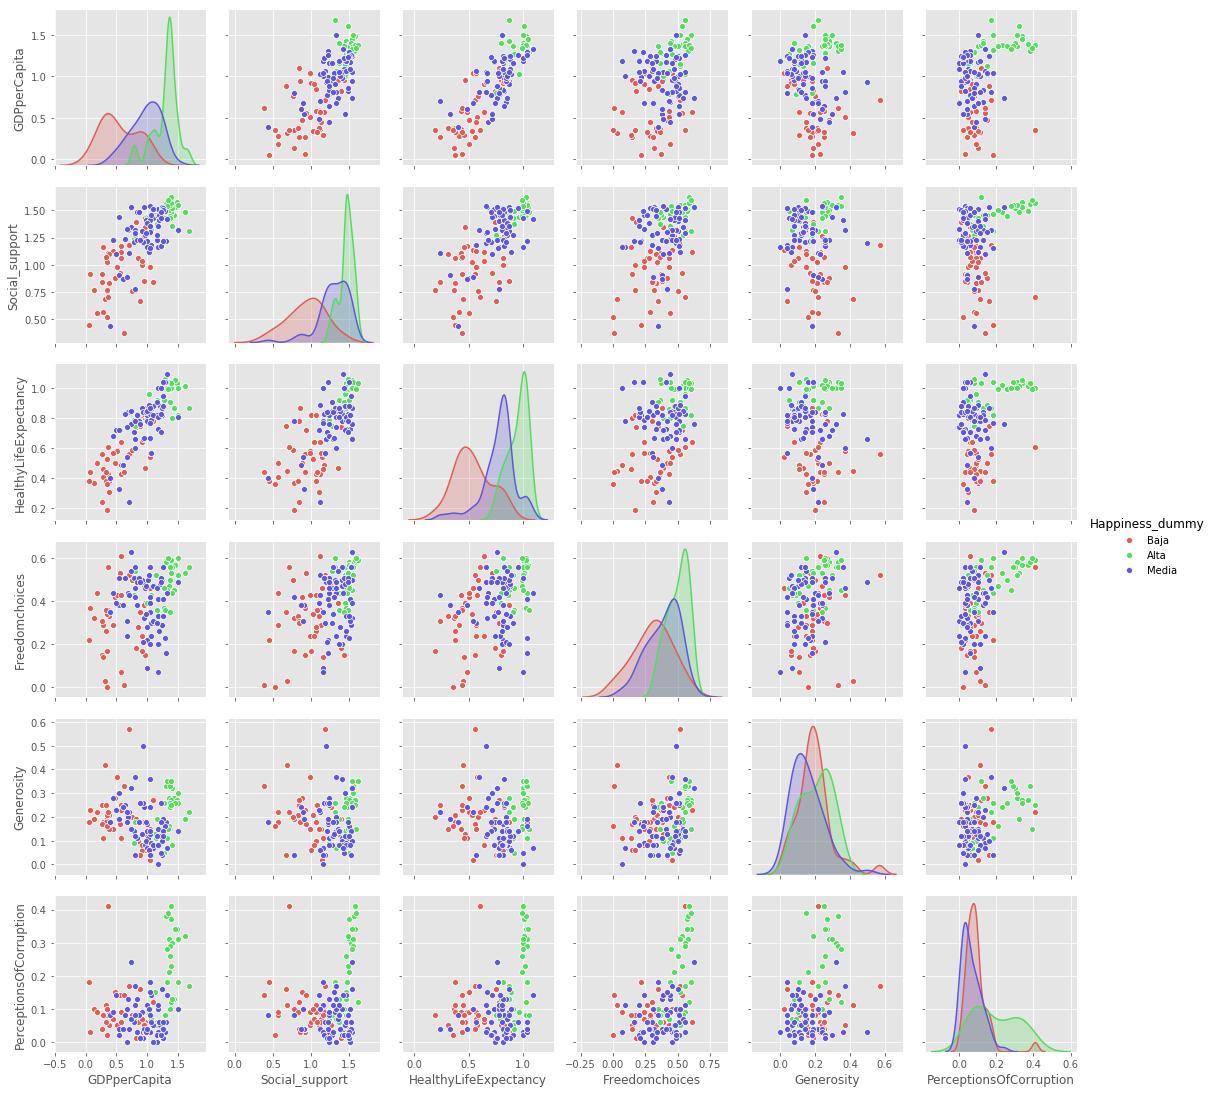

In [28]:
umbrales = (data.Happiness.max() - data.Happiness.min())/3
data["Happiness_dummy"] = data.Happiness.apply(lambda x: "Baja" if (x<(data.Happiness.min()+umbrales)) else ("Media" if (x<(data.Happiness.min()+2*umbrales)) else "Alta"))


data_pairplot = data[['GDPperCapita', 'Social_support',
               'HealthyLifeExpectancy', 'Freedomchoices', 'Generosity',
               'PerceptionsOfCorruption','Happiness_dummy']]

sns.pairplot(data_pairplot, hue='Happiness_dummy', palette="hls");

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


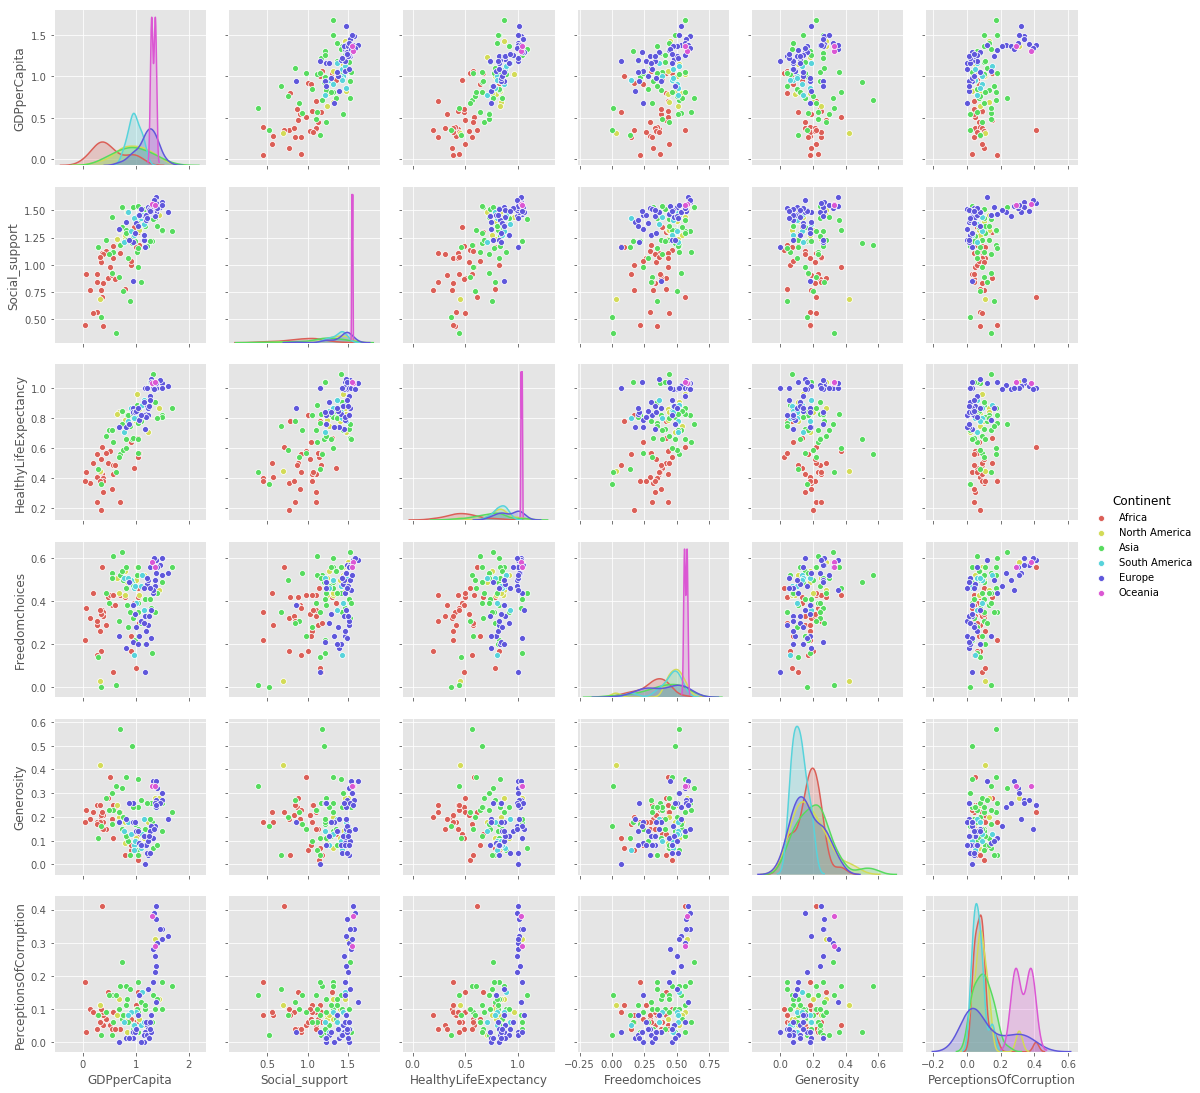

In [29]:
data_pairplot = data[['GDPperCapita', 'Social_support',
               'HealthyLifeExpectancy', 'Freedomchoices', 'Generosity',
               'PerceptionsOfCorruption','Continent']]

sns.pairplot(data_pairplot, hue='Continent', palette="hls");

In [30]:
data_complete.columns

Index(['Country', 'OverallRank', 'Happiness', 'GDPperCapita', 'Social_support',
       'HealthyLifeExpectancy', 'Freedomchoices', 'Generosity',
       'PerceptionsOfCorruption', 'Region', 'Year'],
      dtype='object')

In [31]:
def TopTen(column,year):
    data_year=data_complete.loc[data_complete['Year']==year,:]
    data_year = data_year.sort_values(by=[column],ascending=False)


    data_year.reset_index(drop=True,inplace=True)    
    data_year_10 = data_year.iloc[0:10,:]
    data_year_argentina = data_year.loc[data_year['Country']=="Argentina",:]
    data_year_10 = data_year_10.append(data_year_argentina)

    color_list = ['red' if (x=="Argentina") else "#009966" for x in data_year_10['Country'] ]
    data_year_10['Country'] = (data_year_10.index+1).astype(str)+" - "+data_year_10['Country']    
    f, ax = plt.subplots(figsize=(14,8))
    sns.barplot(data_year_10[column],data_year_10['Country'],  ax=ax, palette = color_list, orient="h")
    plt.title("Top 10 - "+str(column),fontsize=15,weight= 'bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Paises",fontsize=15,weight= 'bold')
    plt.xlabel(str(column),fontsize=15,weight= 'bold')

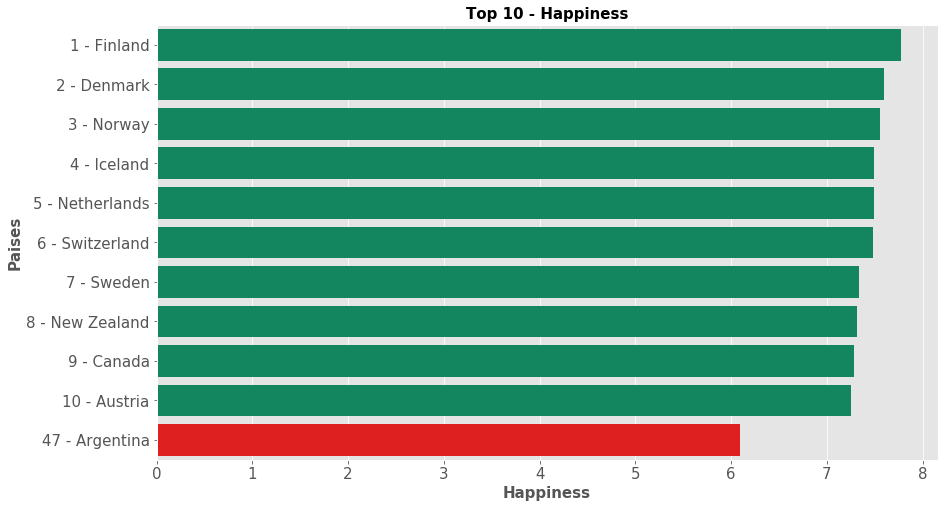

In [32]:
TopTen('Happiness',2019)

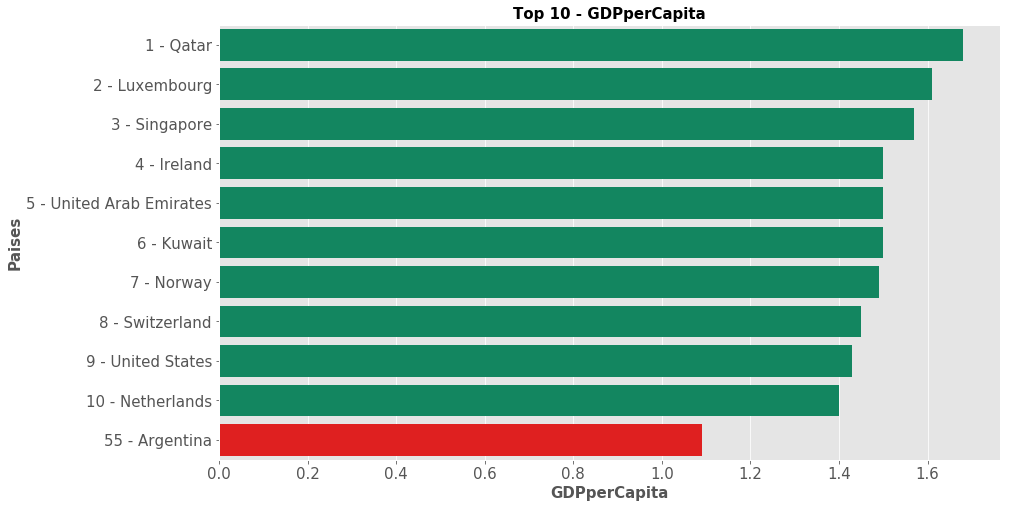

In [33]:
TopTen('GDPperCapita',2019)

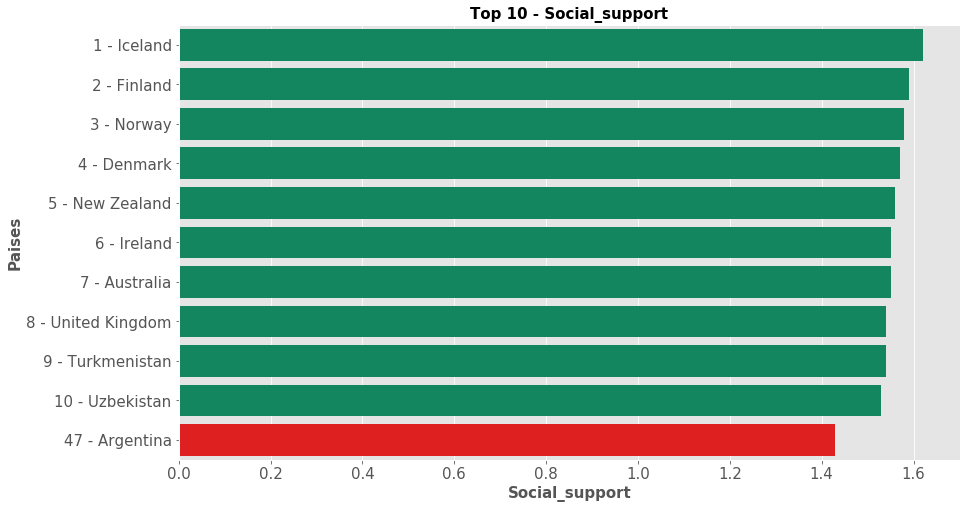

In [34]:
TopTen('Social_support',2019)

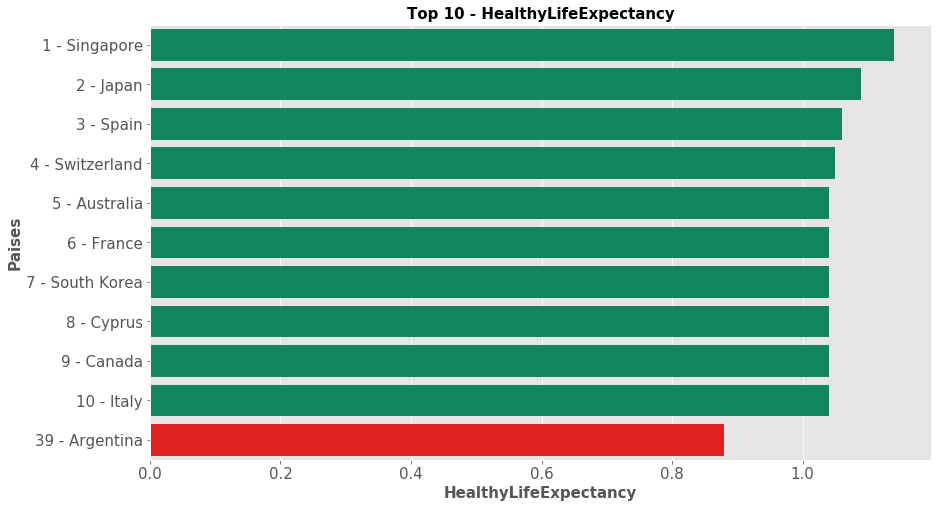

In [35]:
TopTen('HealthyLifeExpectancy',2019)

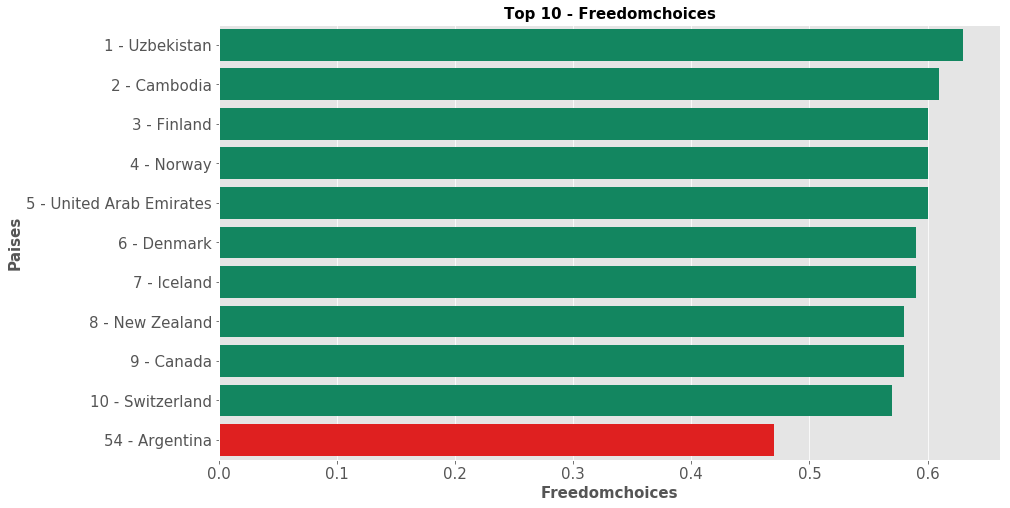

In [36]:
TopTen('Freedomchoices',2019)

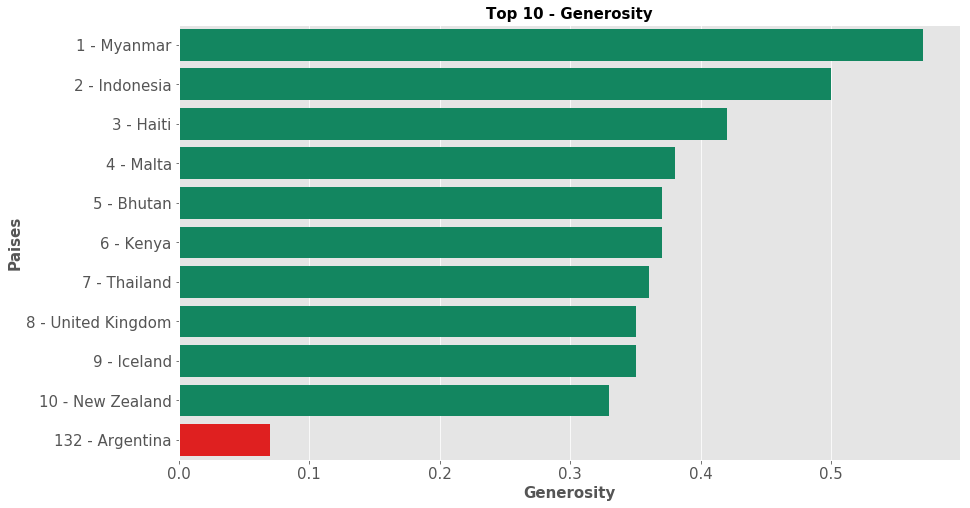

In [37]:
TopTen('Generosity',2019)

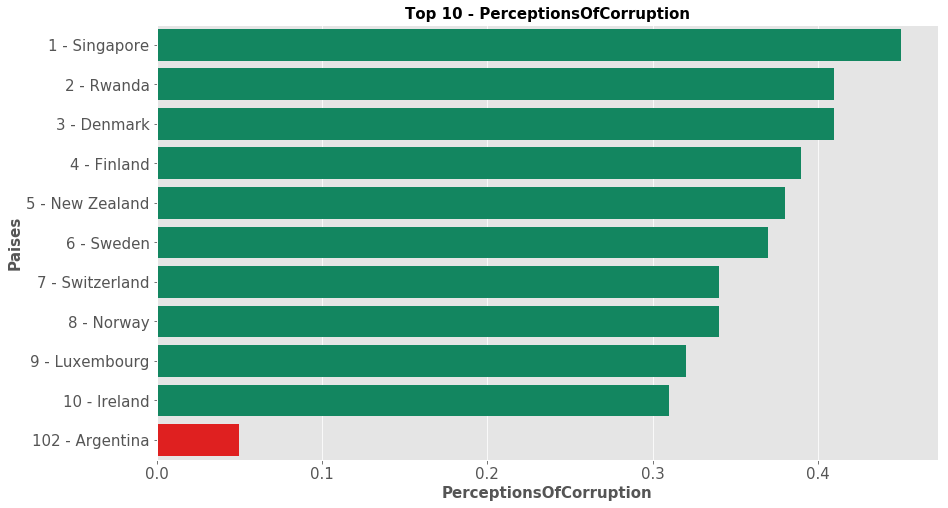

In [38]:
TopTen('PerceptionsOfCorruption',2019)

---
---
<b><a id='section_3'><h4>3. Kmeans</h4></a></b>

Construimos el dataset con los indicadores normalizados que utilizaremos para la confección de clusters en todos los modelos

In [39]:
indicadores = ['GDPperCapita', 'Social_support',
               'HealthyLifeExpectancy', 'Freedomchoices', 'Generosity',
               'PerceptionsOfCorruption']

In [40]:
X= data[indicadores]

In [41]:
scaler=StandardScaler()
X_sc=scaler.fit_transform(X)

Hacemos PCA y nos quedamos con los 2 primeros componentes. El fin de hacer PCA es tener 2 ejes sobre los cuales poder visualizar y analizar los clusters generados

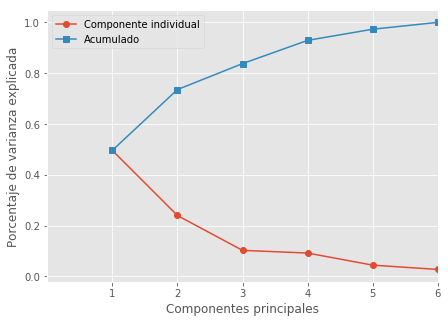

In [42]:
model_pca= PCA(6).fit(X_sc)

plt.figure(figsize = (7, 5))

plt.plot([1, 2, 3, 4, 5, 6], model_pca.explained_variance_ratio_, "-o", label = "Componente individual")
plt.plot([1, 2, 3, 4, 5, 6], np.cumsum(model_pca.explained_variance_ratio_), "-s", label = "Acumulado")

plt.ylabel("Porcentaje de varianza explicada")
plt.xlabel("Componentes principales")
plt.xlim(0.75, 4.25)
plt.xlim(0, 1.05)
plt.xticks([1, 2, 3, 4, 5, 6])
plt.legend(loc = 2)


In [43]:
print("Varianza explicada por los 2 principales componentes de PCA:",model_pca.explained_variance_ratio_.sum().round(2))
pca_results = pd.DataFrame(PCA(2).fit(X_sc).transform(X_sc),columns=['PCA_1','PCA_2'])
pca_results

Varianza explicada por los 2 principales componentes de PCA: 1.0


,PCA_1,PCA_2
0,1.626232,1.743381
1,-2.922841,1.588937
2,-1.619026,0.433966
3,-0.769245,-0.525264
4,-1.354834,2.242755
...,...,...
131,0.008731,-0.713351
132,-0.064917,-1.188665
133,-0.066355,-1.220788
134,0.096366,0.328860


In [44]:
pd.DataFrame(model_pca.components_.T, index =indicadores)

,0,1,2,3,4,5
GDPperCapita,-0.514565,-0.216601,0.060580,0.250879,0.267798,0.741607
Social_support,-0.492101,-0.184285,-0.337622,0.070758,-0.769370,-0.113804
HealthyLifeExpectancy,-0.515895,-0.199484,0.049981,0.196085,0.470997,-0.656714
Freedomchoices,-0.371121,0.373360,-0.292123,-0.771364,0.195467,0.065769
Generosity,-0.027207,0.703129,-0.444868,0.546028,0.093796,0.004239
PerceptionsOfCorruption,-0.297390,0.495521,0.772399,0.021320,-0.259830,-0.038099


Analizamos los índices de Silloute, Calinsky e Inertia para Kmeans

In [45]:
evaluation = []
for k in range(2,9):
    kmeans = KMeans(n_clusters=k, random_state=0) 
    kmeans.fit(X_sc)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    silhouette = silhouette_score(X_sc, labels, metric='euclidean').round(2)
    calinsky = calinski_harabasz_score(X_sc, labels).round()
    inertia = kmeans.inertia_.round()
    evaluation.append([k, silhouette, calinsky, inertia])

evaluation = pd.DataFrame(evaluation, columns=['k', 'silhouette', 'calinsky', 'inertia'])
print("Kmeans evaluation")
evaluation

Kmeans evaluation


,k,silhouette,calinsky,inertia
0,2,0.33,66.0,546.0
1,3,0.35,75.0,384.0
2,4,0.32,65.0,330.0
3,5,0.26,61.0,287.0
4,6,0.25,54.0,264.0
5,7,0.26,49.0,248.0
6,8,0.24,47.0,227.0


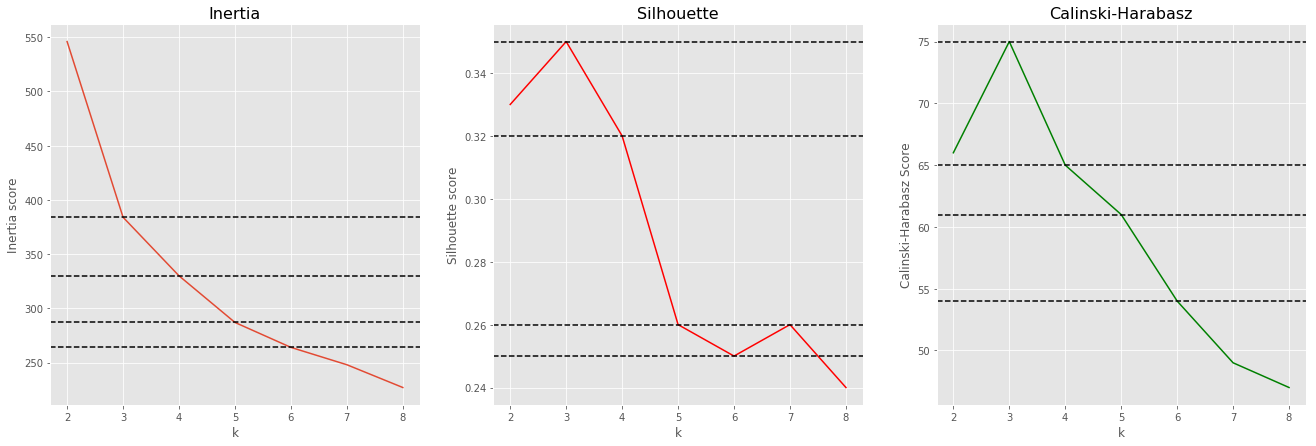

In [46]:
fig,(ax1, ax2, ax3) =plt.subplots(1,3,figsize=(22.5,7))

ax1.plot(evaluation['k'],evaluation['inertia']) 
ax1.set_ylabel('Inertia score') 
ax1.set_xlabel('k')
ax1.set_title("Inertia",size=16)
for i in range(1,5):
    ax1.axhline(evaluation['inertia'][i],color='black',ls="--")

ax2.plot(evaluation['k'],evaluation['silhouette'],color='red') 
ax2.set_ylabel('Silhouette score') 
ax2.set_xlabel('k');
ax2.set_title("Silhouette",size=16)
for i in range(1,5):
    ax2.axhline(evaluation['silhouette'][i],color='black',ls="--")
    
ax3.plot(evaluation['k'],evaluation['calinsky'],color='green') 
ax3.set_ylabel('Calinski-Harabasz Score') 
ax3.set_xlabel('k')
ax3.set_title("Calinski-Harabasz",size=16)
for i in range(1,5):
    ax3.axhline(evaluation['calinsky'][i],color='black',ls="--")

For n_clusters = 2 The average silhouette_score is : 0.33
For n_clusters = 3 The average silhouette_score is : 0.35
For n_clusters = 4 The average silhouette_score is : 0.29
For n_clusters = 5 The average silhouette_score is : 0.27
For n_clusters = 6 The average silhouette_score is : 0.25
For n_clusters = 7 The average silhouette_score is : 0.25
For n_clusters = 8 The average silhouette_score is : 0.24
For n_clusters = 9 The average silhouette_score is : 0.25


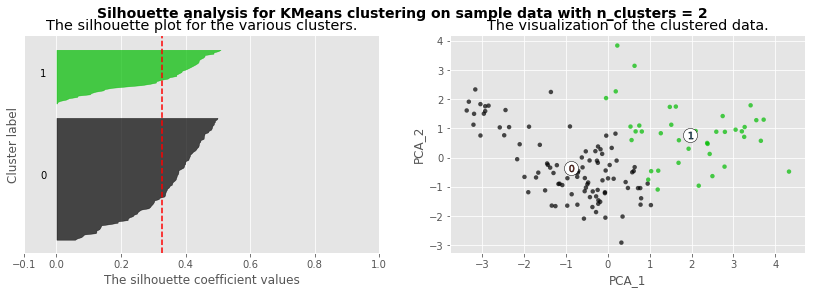

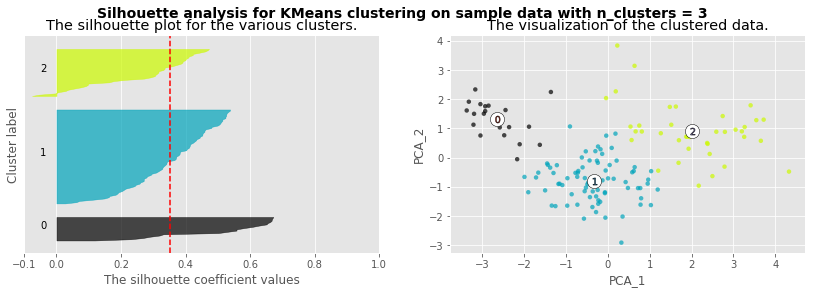

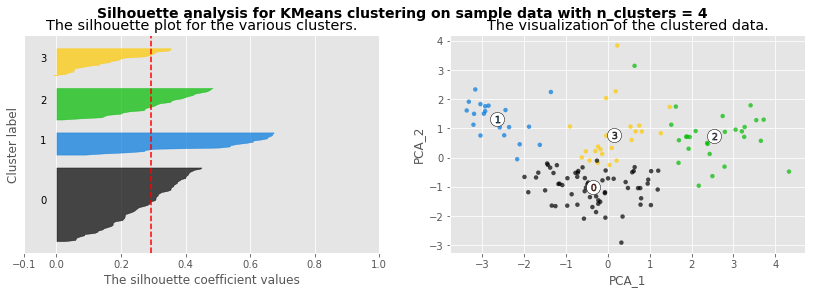

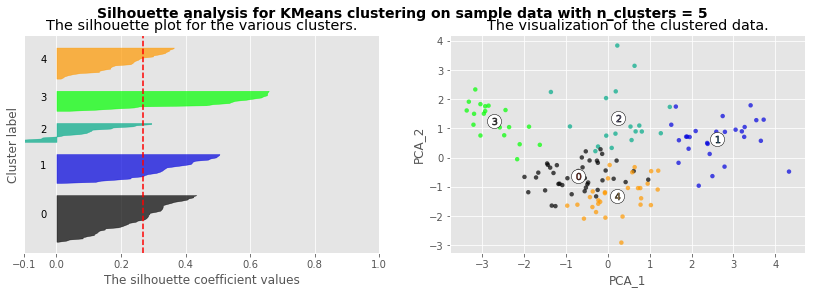

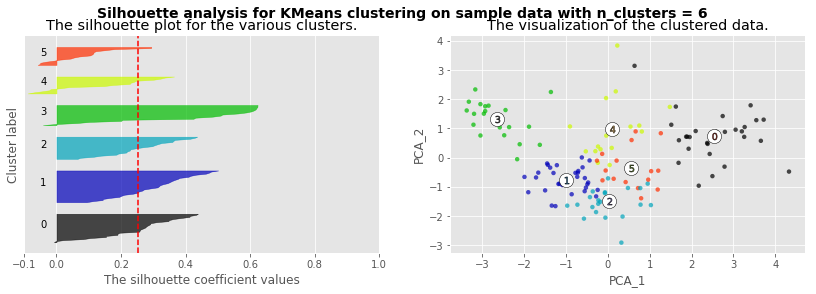

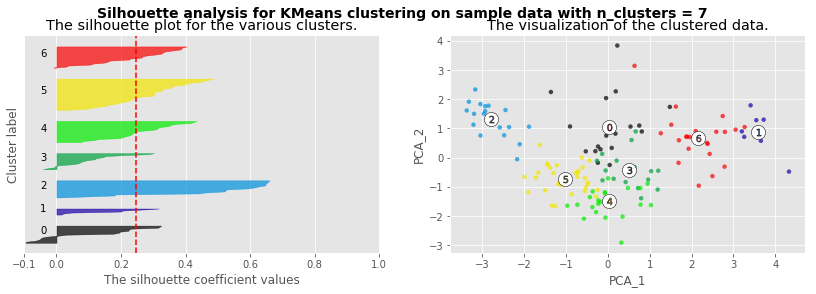

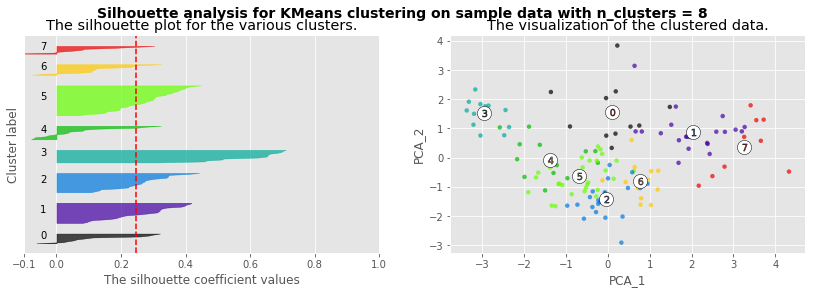

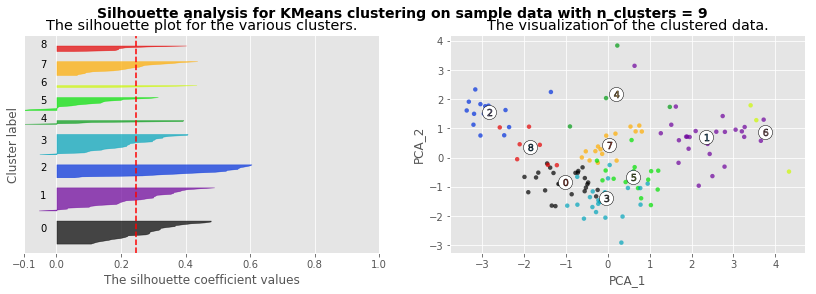

In [47]:
for n_clusters in range(2,10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_sc) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_sc)
    silhouette_avg = silhouette_score(X_sc, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg.round(2))
    sample_silhouette_values = silhouette_samples(X_sc, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)


        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_results['PCA_1'], pca_results['PCA_2'], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    

    centers = clusterer.cluster_centers_
    centers = model_pca.transform(centers)
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PCA_1")
    ax2.set_ylabel("PCA_2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Kmeans con K=3  resulta el valor óptimo para la agrupación

In [48]:
k=3
kmeans = KMeans(n_clusters=k, random_state=3)  
kmeans.fit(X_sc)
labels_km = kmeans.labels_
centroids_km = kmeans.cluster_centers_ 
centroids_km_pca = model_pca.transform(centroids_km)

Analizamos los clusters según región de los paises que lo integran

In [49]:
data['Cluster_kmeans'] = labels_km
clusters_happiness  = data.groupby(['Cluster_kmeans'])['Happiness_dummy'].value_counts().groupby(['Cluster_kmeans']).idxmax()
clusters_happiness_toReplace = {x[0]:x[1] for x in clusters_happiness}
data['Cluster_kmeans'] = data['Cluster_kmeans'].replace(clusters_happiness_toReplace)

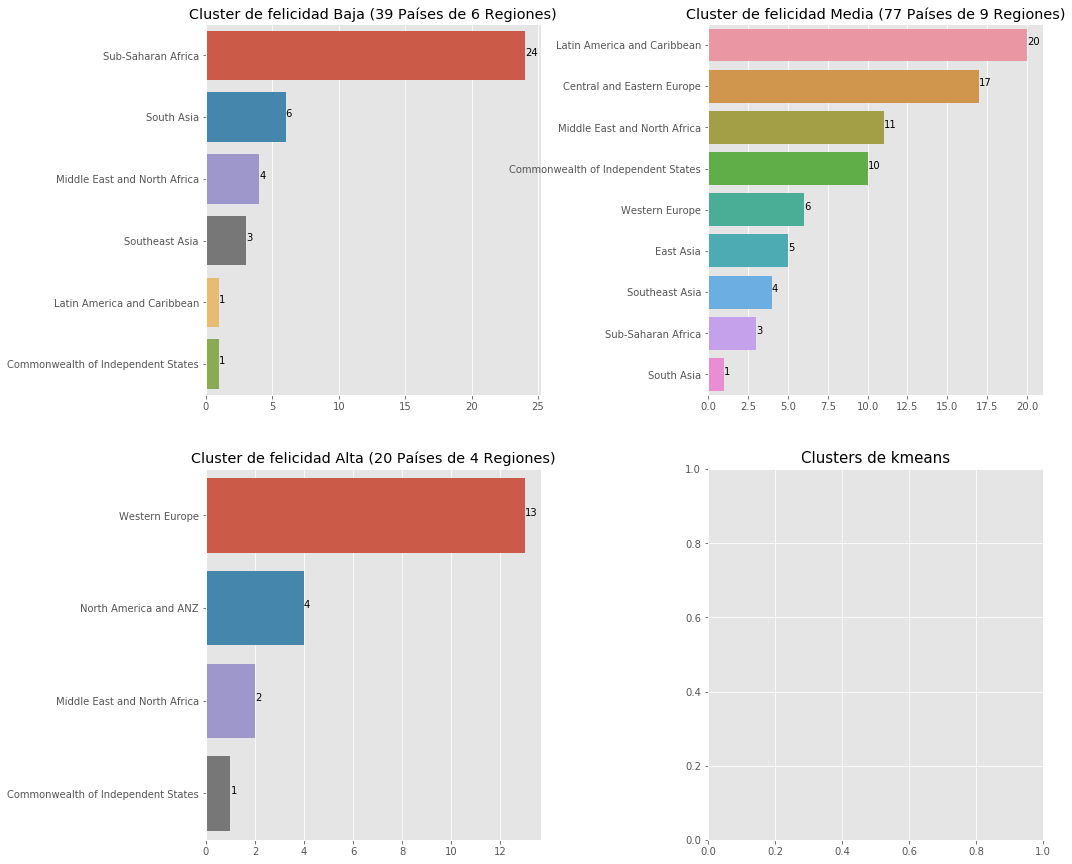

In [50]:


f,ax=plt.subplots(2,2,figsize=(15,15),gridspec_kw={'wspace':0.5})
ax=ax.ravel();

for lbl in range(k):
    total=data.loc[labels_km==lbl,'Region'].value_counts()
    S=data.loc[labels_km==lbl,'Region'].value_counts();
    chart=sns.barplot(y=S.index[:],x=S.values[:],ax=ax[lbl],orient='h') # se podría elegir mostrar menos si fueran muchos
    chart.set_title('Cluster de felicidad ' + clusters_happiness_toReplace[lbl] + ' (' + str(total.sum()) + ' Países de '+ str(len(total)) + ' Regiones)')
    # Le agregamos los totales por Cluster y por Región
    i=0
    for p in ax[lbl].patches:
        _x = p.get_x() + p.get_width()
        _y = p.get_y() + (p.get_height() / 2)
        value = total[i]
        chart.text(_x , _y, value, ha="left")
        i +=1
plt.title("Clusters de kmeans",size=15);

In [51]:
if "Cluster_kmeans" in data_map.columns:
    data_map.drop(columns=['Cluster_kmeans'],inplace=True)
    data_map= data_map.merge(data[['Country','Cluster_kmeans']],on='Country',how='left')
else:
    data_map= data_map.merge(data[['Country','Cluster_kmeans']],on='Country',how='left')
data_map['Cluster_kmeans']=data_map['Cluster_kmeans'].astype(str)

In [52]:
colormap={'nan': 'white',
         'Baja': 'red',
         'Media':'blue',
         'Alta': 'green'
         }
color_list = data_map['Cluster_kmeans'].replace(colormap)

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\geopandas\plotting.py:494: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


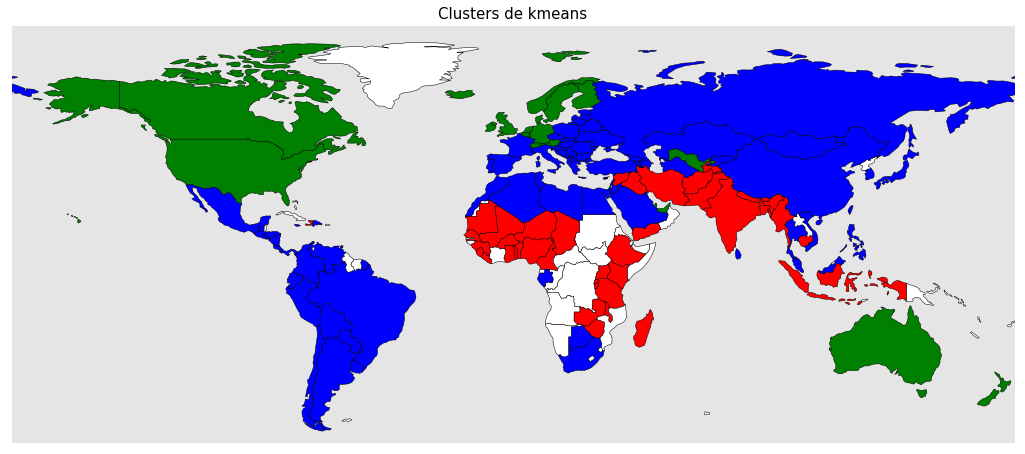

In [53]:
fig, ax = plt.subplots(figsize=(18, 15))
data_map.plot('Cluster_kmeans',edgecolor='black', color=color_list, legend=True, ax=ax);
plt.xlim(-180,180)
plt.ylim(-60,90)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Clusters de kmeans",size=15);

Analizamos los clusters en función de las etiqueta de felicidad generadas

              precision    recall  f1-score   support

        Alta       0.95      0.58      0.72        33
        Baja       0.77      0.75      0.76        40
       Media       0.69      0.84      0.76        63

    accuracy                           0.75       136
   macro avg       0.80      0.72      0.74       136
weighted avg       0.78      0.75      0.75       136



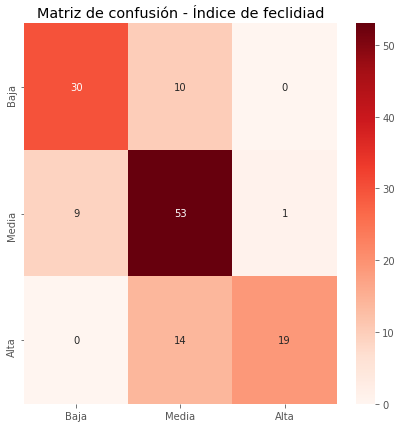

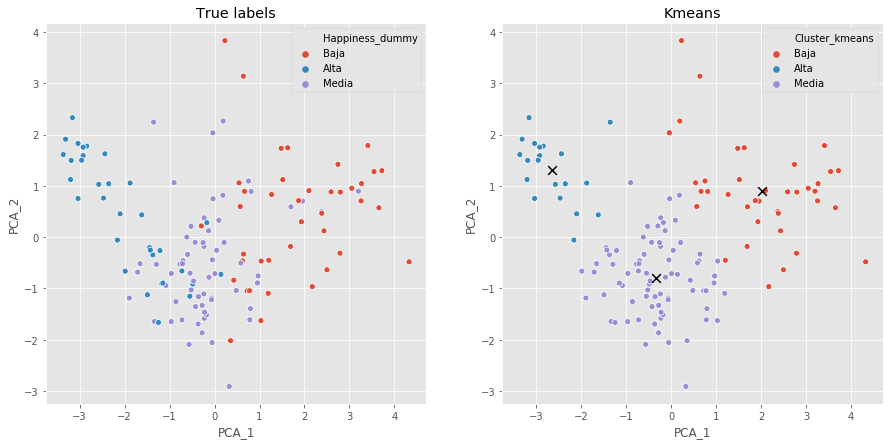

In [54]:
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix(data['Happiness_dummy'],data['Cluster_kmeans'],labels=['Baja','Media','Alta']),annot=True, cmap="Reds", fmt=".0f",
           yticklabels=['Baja','Media','Alta'],
           xticklabels=['Baja','Media','Alta']);
plt.title("Matriz de confusión - Índice de feclidiad")

print(classification_report(data['Happiness_dummy'],data['Cluster_kmeans']))



f,ax=plt.subplots(1,2,figsize=(15,7))
sns.scatterplot(pca_results['PCA_1'], pca_results['PCA_2'],hue=data['Happiness_dummy'],ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(pca_results['PCA_1'], pca_results['PCA_2'],hue=data['Cluster_kmeans'],ax=ax[1])
ax[1].set_title('Kmeans')
plt.scatter(centroids_km_pca[:,0],centroids_km_pca[:,1],marker='x',s=75, color='black');

---
---
<b><a id='section_4'><h4>4. Clúster jerárquicos</h4></a></b>

Text(0,0.5,'Data points')

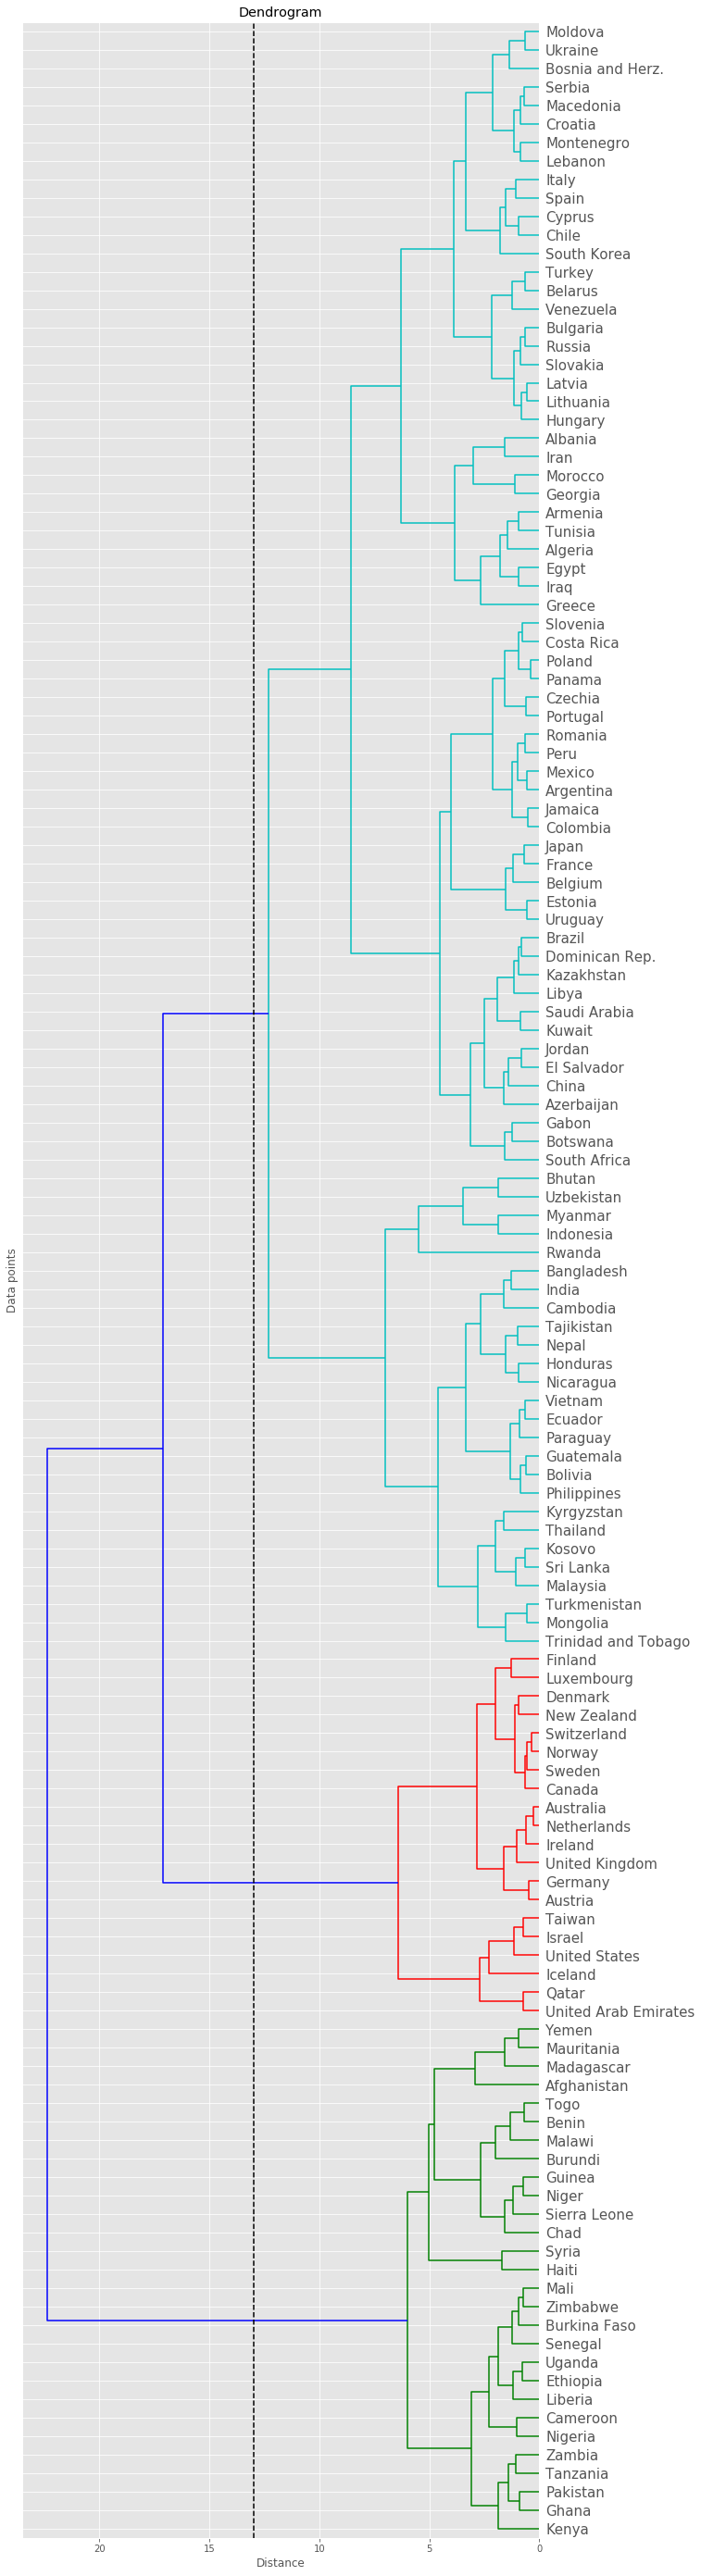

In [55]:
limite = 13      
z = linkage(X_sc, method='ward')

plt.figure(figsize=(10,50))
dendrogram(z, labels=data["Country"].values, leaf_font_size=15, color_threshold=limite, orientation='left')

plt.vlines(limite,0,X_sc.shape[0]*100,linestyle='--') 
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Data points')

Calculamos Silhoutte y Calinsky para evaluar cuál es la cantidad óptima de clusters

In [56]:
data['Cluster_jerarquico'] = fcluster(z, k, criterion='maxclust')
clusters_happiness  = data.groupby(['Cluster_jerarquico'])['Happiness_dummy'].value_counts().groupby(['Cluster_jerarquico']).idxmax()
clusters_happiness_toReplace = {x[0]:x[1] for x in clusters_happiness}
data['Cluster_jerarquico'] = data['Cluster_jerarquico'].replace(clusters_happiness_toReplace)

In [57]:
evaluation = []
for k in range(2,9):
    labels = fcluster(linkage(X_sc, method='ward'), k, criterion='maxclust')
    silhouette = silhouette_score(X_sc, labels, metric='euclidean').round(2)
    calinsky = calinski_harabasz_score(X_sc, labels).round()
    evaluation.append([k, silhouette, calinsky])

evaluation = pd.DataFrame(evaluation, columns=['k', 'silhouette', 'calinsky'])
print("Cluster jerarquicos evaluation")
evaluation

Cluster jerarquicos evaluation


,k,silhouette,calinsky
0,2,0.33,59.0
1,3,0.32,63.0
2,4,0.28,61.0
3,5,0.24,54.0
4,6,0.24,49.0
5,7,0.24,46.0
6,8,0.24,43.0


Cluster jerarquicos evaluation


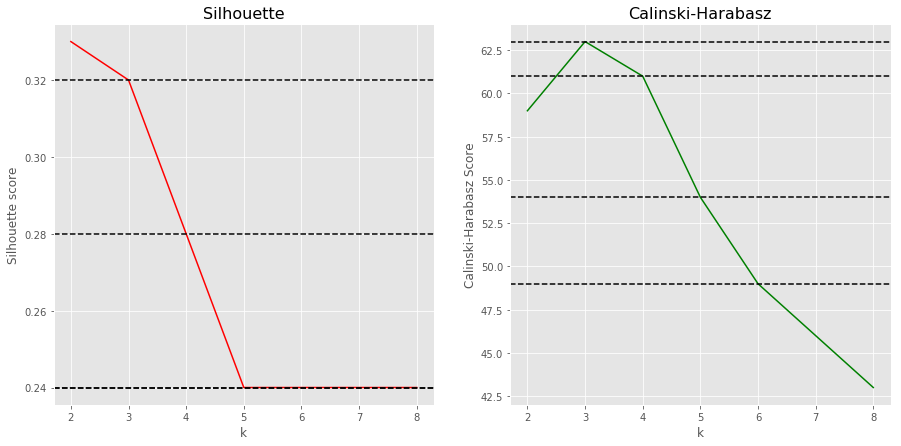

In [58]:
fig,(ax2, ax3) =plt.subplots(1,2,figsize=(15,7))

ax2.plot(evaluation['k'],evaluation['silhouette'],color='red') 
ax2.set_ylabel('Silhouette score') 
ax2.set_xlabel('k');
ax2.set_title("Silhouette",size=16)
for i in range(1,5):
    ax2.axhline(evaluation['silhouette'][i],color='black',ls="--")
    
ax3.plot(evaluation['k'],evaluation['calinsky'],color='green') 
ax3.set_ylabel('Calinski-Harabasz Score') 
ax3.set_xlabel('k')
ax3.set_title("Calinski-Harabasz",size=16)
for i in range(1,5):
    ax3.axhline(evaluation['calinsky'][i],color='black',ls="--")

print("Cluster jerarquicos evaluation")

Al igual que en Kmeans, 3 clusters pareciera ser el óptimo para el método de cluster jerárquicos.  
Analizamos los clusters en función de las regiones

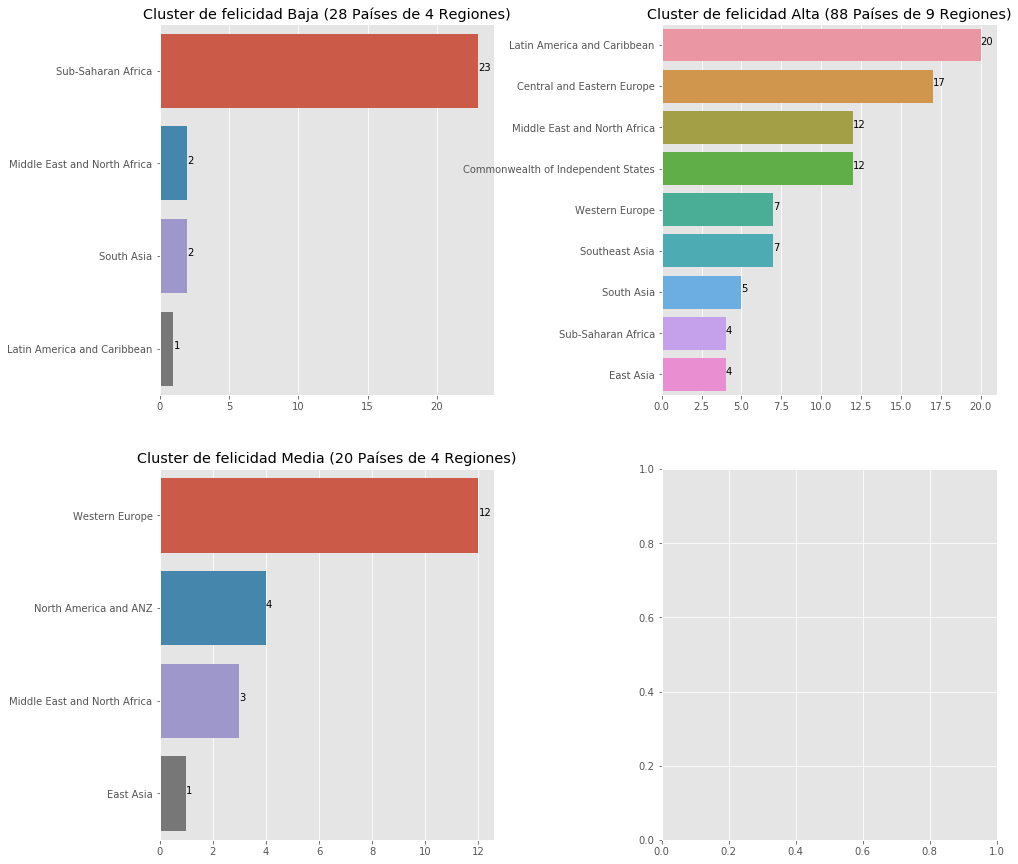

In [59]:
k=3
labels_hc=fcluster(z, k, criterion='maxclust');     
labels_hc = pd.Series(labels_hc).apply(lambda x: 0 if (x==1) else (1 if (x==3) else 2))

f,ax=plt.subplots(2,2,figsize=(15,15),gridspec_kw={'wspace':0.5})
ax=ax.ravel();

for lbl in range(k):
    total=data.loc[labels_hc==lbl,'Region'].value_counts()
    S=data.loc[labels_hc==lbl,'Region'].value_counts();
    chart=sns.barplot(y=S.index[:],x=S.values[:],ax=ax[lbl],orient='h') # se podría elegir mostrar menos si fueran muchos
    chart.set_title('Cluster de felicidad ' + clusters_happiness_toReplace[lbl+1] + ' (' + str(total.sum()) + ' Países de '+ str(len(total)) + ' Regiones)')
    # Le agregamos los totales por Cluster y por Región
    i=0
    for p in ax[lbl].patches:
        _x = p.get_x() + p.get_width()
        _y = p.get_y() + (p.get_height() / 2)
        value = total[i]
        chart.text(_x , _y, value, ha="left")
        i +=1
    

In [60]:
if "Cluster_jerarquico" in data_map.columns:
    data_map.drop(columns=['Cluster_jerarquico'],inplace=True)
    data_map= data_map.merge(data[['Country','Cluster_jerarquico']],on='Country',how='left')
else:
    data_map= data_map.merge(data[['Country','Cluster_jerarquico']],on='Country',how='left')
data_map['Cluster_jerarquico']=data_map['Cluster_jerarquico'].astype(str)

In [61]:
colormap={'nan': 'white',
         'Baja': 'red',
         'Media':'blue',
         'Alta': 'green'
         }
color_list = data_map['Cluster_jerarquico'].replace(colormap)

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\geopandas\plotting.py:494: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


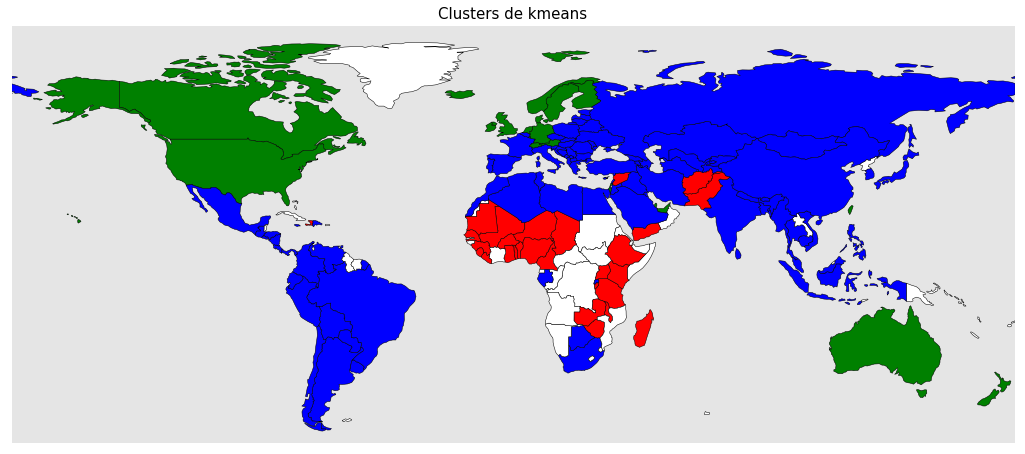

In [62]:
fig, ax = plt.subplots(figsize=(18, 15))
data_map.plot('Cluster_jerarquico',edgecolor='black', color=color_list, legend=True, ax=ax);
plt.xlim(-180,180)
plt.ylim(-60,90)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Clusters de kmeans",size=15);

Analizamos los clusters en función de las etiquetas de felicidad generadas

              precision    recall  f1-score   support

        Alta       1.00      0.61      0.75        33
        Baja       0.82      0.57      0.68        40
       Media       0.66      0.92      0.77        63

    accuracy                           0.74       136
   macro avg       0.83      0.70      0.73       136
weighted avg       0.79      0.74      0.74       136



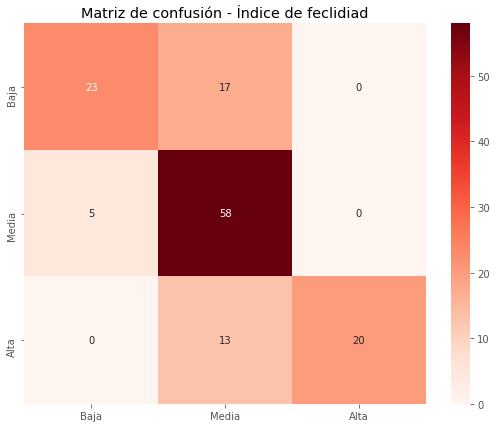

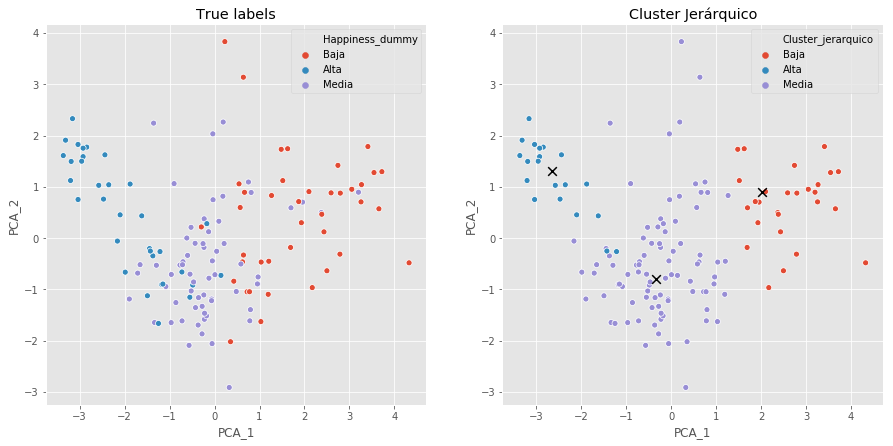

In [63]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(data['Happiness_dummy'],data['Cluster_jerarquico'],labels=['Baja','Media','Alta']),annot=True, cmap="Reds", fmt=".0f",
           yticklabels=['Baja','Media','Alta'],
           xticklabels=['Baja','Media','Alta']);
plt.title("Matriz de confusión - Índice de feclidiad")

print(classification_report(data['Happiness_dummy'],data['Cluster_jerarquico']))


f,ax=plt.subplots(1,2,figsize=(15,7))
sns.scatterplot(pca_results['PCA_1'], pca_results['PCA_2'],hue=data['Happiness_dummy'],ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(pca_results['PCA_1'], pca_results['PCA_2'],hue=data['Cluster_jerarquico'],ax=ax[1])
ax[1].set_title('Cluster Jerárquico')
plt.scatter(centroids_km_pca[:,0],centroids_km_pca[:,1],marker='x',s=75, color='black');

---
---
<b><a id='section_5'><h4>5. DBSCAN</h4></a></b>

Analizamos los valores de Silhoute y Calisnky para distintos epsilons para DBSCAN

D.shape:  (136, 136) 



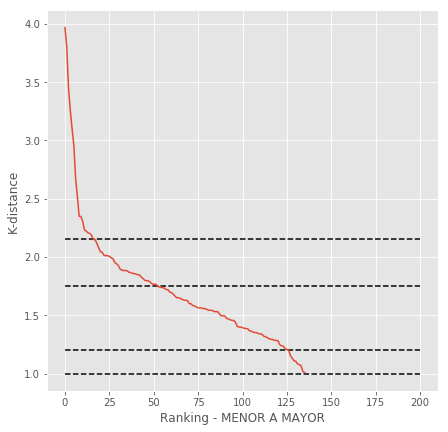

In [64]:
minPts=14

k=minPts-1

D=squareform(pdist(X_sc))
print("D.shape: ", D.shape,  "\n")

k_distances=np.zeros(D.shape[0]); 

for i in range(D.shape[0]):          
    distances=np.sort(D[i]);       
    k_distances[i]=distances[k];   
    
k_distances=np.sort(k_distances);    
k_distances=k_distances[::-1];          

plt.figure(figsize=(7,7))
plt.plot(k_distances);
plt.xlabel('Ranking - MENOR A MAYOR');
plt.ylabel('K-distance');
plt.hlines([2.15,1.75, 1.2, 1],0,200,linestyles='dashed');


In [65]:
lista_epsilon = [(x/10)+1 for x in range (0,20)]

In [66]:
evaluation = []
for eps in lista_epsilon:
    labels = DBSCAN(eps=eps, min_samples=10).fit_predict(X_sc)
    silhouette = silhouette_score(X_sc, labels, metric='euclidean').round(2)
    calinsky = calinski_harabasz_score(X_sc, labels).round()
    evaluation.append([eps, silhouette, calinsky])

evaluation = pd.DataFrame(evaluation, columns=['eps', 'silhouette', 'calinsky'])
print("Cluster jerarquicos evaluation")
evaluation

Cluster jerarquicos evaluation


,eps,silhouette,calinsky
0,1.0,0.03,19.0
1,1.1,0.16,30.0
2,1.2,0.16,31.0
3,1.3,0.23,33.0
4,1.4,0.25,39.0
5,1.5,0.25,27.0
6,1.6,0.25,8.0
7,1.7,0.27,9.0
8,1.8,0.32,10.0
9,1.9,0.32,10.0


DBSCAN evaluation


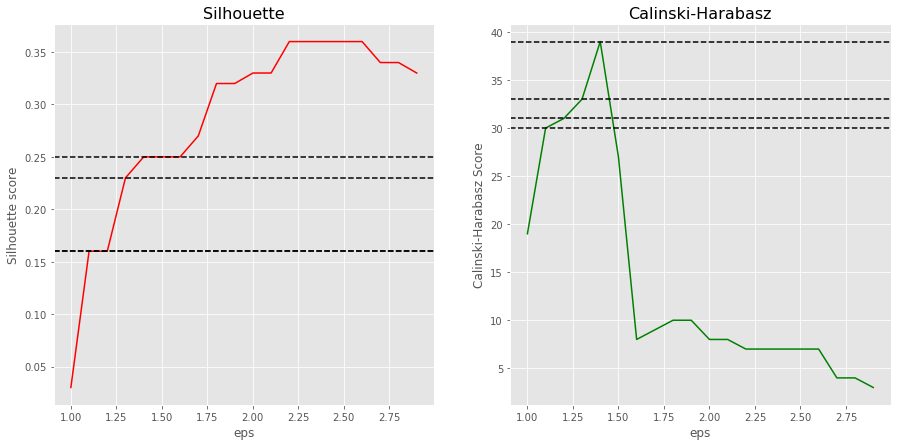

In [67]:
fig,(ax2, ax3) =plt.subplots(1,2,figsize=(15,7))

ax2.plot(evaluation['eps'],evaluation['silhouette'],color='red') 
ax2.set_ylabel('Silhouette score') 
ax2.set_xlabel('eps');
ax2.set_title("Silhouette",size=16)
for i in range(1,5):
    ax2.axhline(evaluation['silhouette'][i],color='black',ls="--")
    
ax3.plot(evaluation['eps'],evaluation['calinsky'],color='green') 
ax3.set_ylabel('Calinski-Harabasz Score') 
ax3.set_xlabel('eps')
ax3.set_title("Calinski-Harabasz",size=16)
for i in range(1,5):
    ax3.axhline(evaluation['calinsky'][i],color='black',ls="--")

print("DBSCAN evaluation")

In [68]:
dbscan = DBSCAN(eps=1.1, min_samples=10)
data['Cluster_DBSCAN']  = dbscan.fit_predict(X_sc)


clusters_happiness_toReplace= {-1: 'Baja', 0: 'Alta', 1: 'Media'}
data['Cluster_DBSCAN'] = data['Cluster_DBSCAN'].replace(clusters_happiness_toReplace)

Analizamos los clusters encontrados por región

In [69]:
if "Cluster_DBSCAN" in data_map.columns:
    data_map.drop(columns=['Cluster_DBSCAN'],inplace=True)
    data_map= data_map.merge(data[['Country','Cluster_DBSCAN']],on='Country',how='left')
else:
    data_map= data_map.merge(data[['Country','Cluster_DBSCAN']],on='Country',how='left')
data_map['Cluster_DBSCAN']=data_map['Cluster_DBSCAN'].astype(str)

In [70]:
colormap={'nan': 'white',
         'Baja': 'red',
         'Media':'blue',
         'Alta': 'green'
         }
color_list = data_map['Cluster_DBSCAN'].replace(colormap)

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\geopandas\plotting.py:494: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


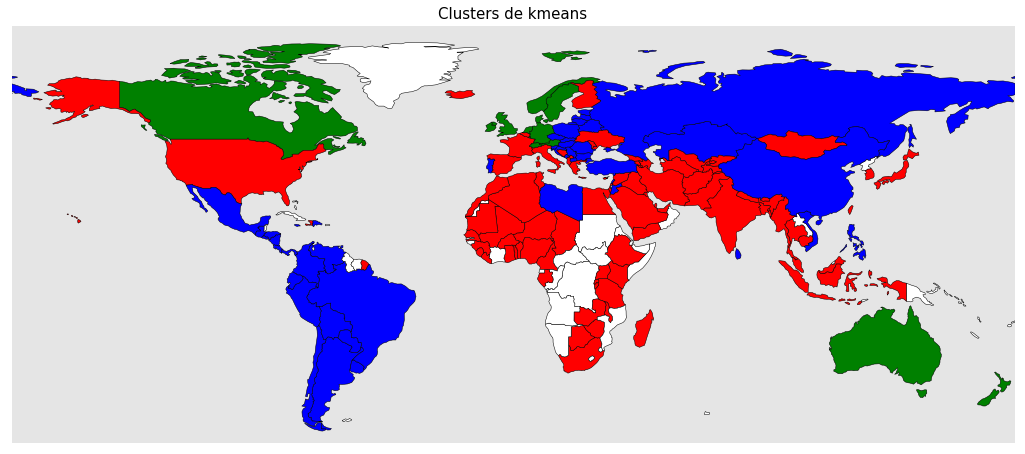

In [71]:
fig, ax = plt.subplots(figsize=(18, 15))
data_map.plot('Cluster_DBSCAN',edgecolor='black', color=color_list, legend=True, ax=ax);
plt.xlim(-180,180)
plt.ylim(-60,90)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Clusters de kmeans",size=15);

Analizamos los clusters en función de las etiquetas de felicidad

              precision    recall  f1-score   support

        Alta       1.00      0.39      0.57        33
        Baja       0.49      0.95      0.65        40
       Media       0.76      0.56      0.64        63

    accuracy                           0.63       136
   macro avg       0.75      0.63      0.62       136
weighted avg       0.74      0.63      0.63       136



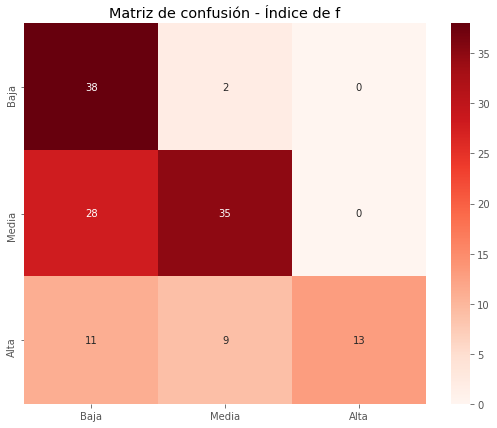

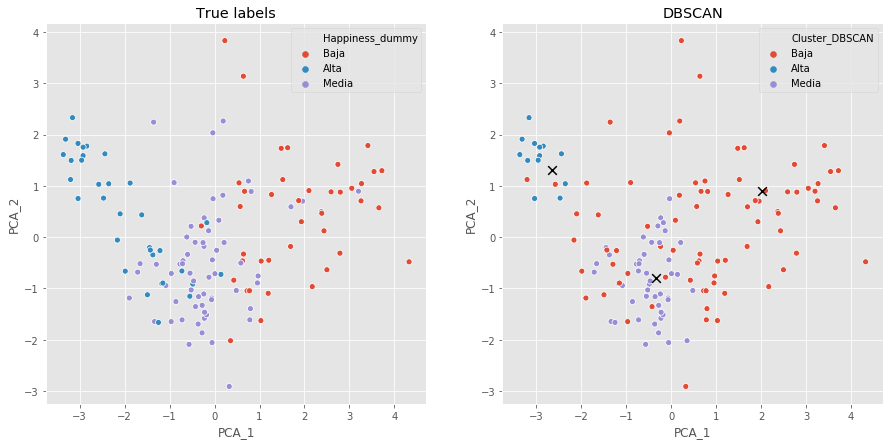

In [72]:


plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(data['Happiness_dummy'],data['Cluster_DBSCAN'],labels=['Baja','Media','Alta']),annot=True, cmap="Reds", fmt=".0f",
           yticklabels=['Baja','Media','Alta'],
           xticklabels=['Baja','Media','Alta']);
plt.title("Matriz de confusión - Índice de f")

print(classification_report(data['Happiness_dummy'],data['Cluster_DBSCAN']))


f,ax=plt.subplots(1,2,figsize=(15,7))
sns.scatterplot(pca_results['PCA_1'], pca_results['PCA_2'],hue=data['Happiness_dummy'],ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(pca_results['PCA_1'], pca_results['PCA_2'],hue=data['Cluster_DBSCAN'],ax=ax[1])
ax[1].set_title('DBSCAN')
plt.scatter(centroids_km_pca[:,0],centroids_km_pca[:,1],marker='x',s=75, color='black');

DBSCAN pareciera ser el peor modelo para la clusterización de este problema. Esto se debe a que no existen zonas de baja densidad que separen con claridad los clusters

---
---
<b><a id='section_6'><h4>6. Resultados</h4></a></b>

Debido a que Kmeans es el que presentar mejores resultados, utilizamos Kmeans para visualizar los clusters para todos los años

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

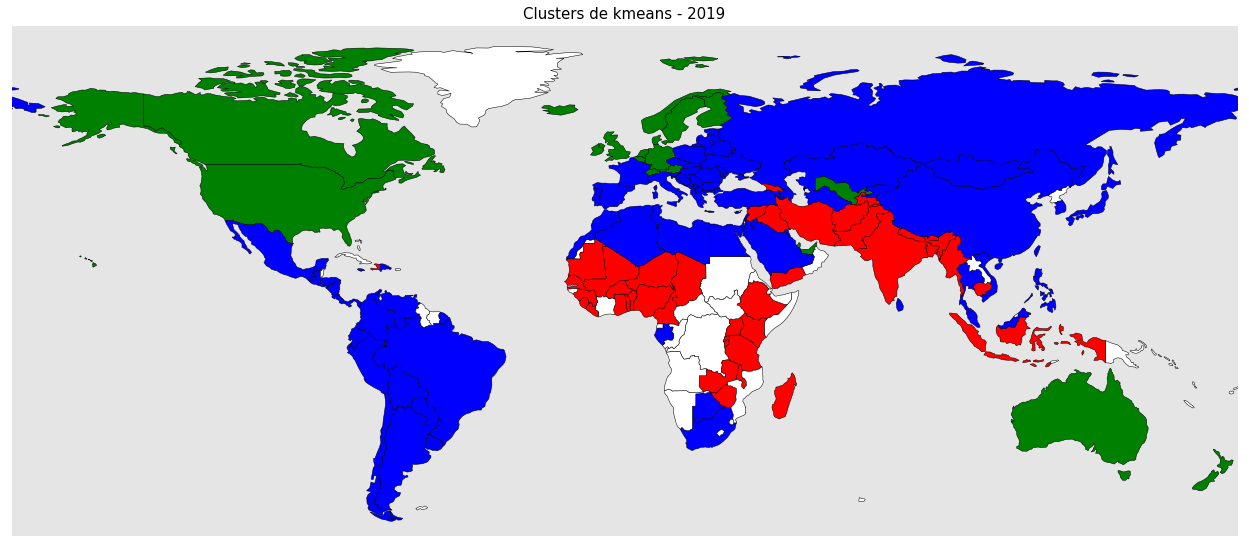

In [73]:
year=2019
data=data_complete.loc[data_complete['Year']==year,:]

data.dropna(inplace=True)
data.isnull().sum()


umbrales = (data.Happiness.max() - data.Happiness.min())/3
data["Happiness_dummy"] = data.Happiness.apply(lambda x: "Baja" if (x<(data.Happiness.min()+umbrales)) else ("Media" if (x<(data.Happiness.min()+2*umbrales)) else "Alta"))

X= data[indicadores]
scaler=StandardScaler()
X_sc=scaler.fit_transform(X)

k=3

kmeans = KMeans(n_clusters=k, random_state=3)  
kmeans.fit(X_sc)
labels_km = kmeans.labels_
data['Cluster_kmeans'] = labels_km
clusters_happiness  = data.groupby(['Cluster_kmeans'])['Happiness_dummy'].value_counts().groupby(['Cluster_kmeans']).idxmax()
clusters_happiness_toReplace = {x[0]:x[1] for x in clusters_happiness}
data['Cluster_kmeans'] = data['Cluster_kmeans'].replace(clusters_happiness_toReplace)

if "Cluster_kmeans" in data_map.columns:
    data_map.drop(columns=['Cluster_kmeans'],inplace=True)
    data_map= data_map.merge(data[['Country','Cluster_kmeans']],on='Country',how='left')
else:
    data_map= data_map.merge(data[['Country','Cluster_kmeans']],on='Country',how='left')
data_map['Cluster_kmeans']=data_map['Cluster_kmeans'].astype(str)

color_list = data_map['Cluster_kmeans'].replace(colormap)

fig, ax = plt.subplots(figsize=(22, 18))
data_map.plot('Cluster_kmeans',edgecolor='black', color=color_list, legend=True, ax=ax);
plt.xlim(-180,180)
plt.ylim(-60,90)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Clusters de kmeans - "+str(year),size=15);